In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data=pd.read_csv('credit_card_default_analysis.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Размер кредитного лимита

Рассмотрим гистограммы для размера кредитного лимита

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000016E2AEB8>,
      dtype=object)

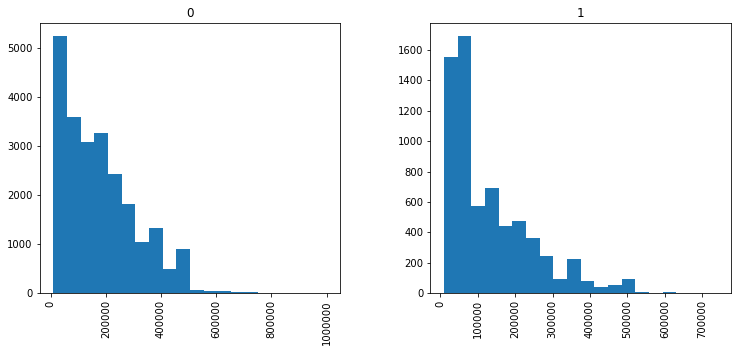

In [12]:
data.hist(column='LIMIT_BAL',by='default',figsize=(12,5),bins=20)

Сложно сказать что-то о смещении и средних, однако можно точно сказать, что выборка не является нормальной, так как суммы сконцентрированы в районе нуля. t-критерии, соответственно, здесь не являются подходящими. Для проверки равенства медианных значений из пункта (а) будем использовать бутстреп.

Дополнительно проверим на нормальность:

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([ 10000,  10000,  10000, ..., 710000, 720000, 740000], dtype=int64)),
 (106735.76934970936, 130109.65641952983, 0.924682934532048))

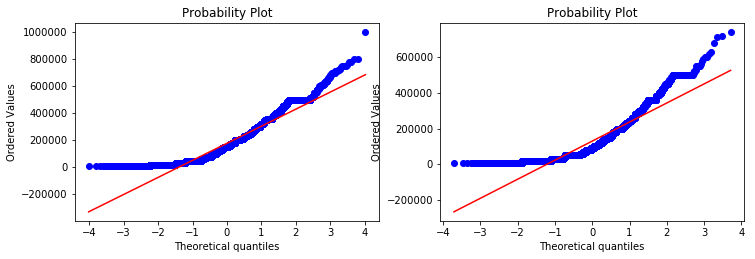

In [21]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.LIMIT_BAL[data.default==0], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.LIMIT_BAL[data.default==1], dist="norm", plot=pylab)

Видим, что значения не совпадают с нормальным распределением в районе нуля. Тот же результат, что мы видели на гистограммах.

In [23]:
def get_bootstrap_samples(data,n_samples):
    index=np.random.randint(0,len(data),(n_samples,len(data)))
    samples=data[index]
    return samples

In [27]:
limits_nodef=np.array(data.LIMIT_BAL[data.default==0])
limits_def=np.array(data.LIMIT_BAL[data.default==1])

In [28]:
nodeft=get_bootstrap_samples(limits_nodef,1000)
deft=get_bootstrap_samples(limits_def,1000)

In [35]:
nodeft

array([[ 70000, 150000,  50000, ..., 500000, 230000, 100000],
       [180000, 100000,  20000, ..., 230000, 310000,  20000],
       [ 70000, 150000, 130000, ..., 180000,  90000, 200000],
       ...,
       [ 70000,  80000,  20000, ...,  10000, 200000, 250000],
       [100000, 130000,  80000, ..., 200000,  80000, 130000],
       [170000, 390000,  50000, ..., 200000,  50000,  60000]], dtype=int64)

In [40]:
statist=np.median(nodeft,axis=1)-np.median(deft,axis=1)

(array([  7.,   0.,   0.,   0.,   0., 947.,   0.,   0.,   0.,  46.]),
 array([50000., 52000., 54000., 56000., 58000., 60000., 62000., 64000.,
        66000., 68000., 70000.]),
 <a list of 10 Patch objects>)

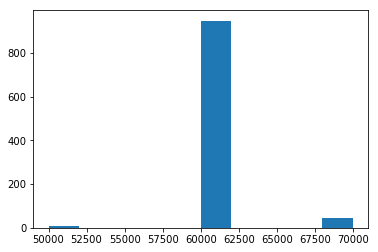

In [43]:
plt.hist(statist)

In [41]:
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [42]:
stat_intervals(statist,0.05)

array([60000., 70000.])

Таким образом, разница медиан лежит в диапазоне от 60 до 70 тысяч с вероятностью 0.95. То есть, лимиты для тех, кто вернул кредиты были выше на 60-70 тысяч.

Для проверки непараметрическим критерием, будем использовать перестановочный критерий, так как он использует максимальное количество информации, проверяя гипотезу:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [44]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [45]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [46]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [47]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [48]:
permutation_test(limits_nodef, limits_def, max_permutations = 10000)

0.0001

p-value 0.0001, значит можем отвергнуть гипотезу о равенстве распределений. Имеется сдвиг, как и показал нам бутстреп. 

С практической точки зрения здесь есть некоторая неясность. По результатам мы можем сделать выводы, что те, кому выдали больше лучше платят. Но решение о выдаче, очевидно, принималось на основании оценки вероятности возврата, соответственно, лучшие клиенты получили большие лимиты. С этой точки зрения результаты практически значимы. Мы можем делать какие-то выводы о процессе кредитования.  

Однако если мы хотим делать выводы на будущее - какой лимит давать, чтобы люди лучше отдавали, то логика чем больше, тем лучше не работает - как было сказано выше, лимиты уже назначались исходя из прогнозируемого качества.

### 2. Пол.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019E78588>,
      dtype=object)

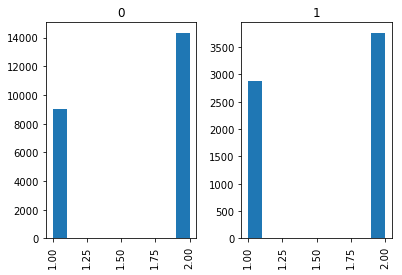

In [49]:
data.hist(column='SEX',by='default')

По гистограмме можно заподозрить, что доля мужчин в дефолтных кредитах выше. Проверим это.

In [55]:
female_nodef=np.array((data.SEX[data.default==0]==2)*1)
female_def=np.array((data.SEX[data.default==1]==2)*1)

In [59]:
def confint_2shares(data1,data2,alpha=0.05):
    p1=data1.mean()
    p2=data2.mean()
    n1=data1.shape[0]
    n2=data2.shape[0]
    z=stats.norm.ppf(1-alpha/2)
    left=p1-p2-z*math.sqrt(p1*(1-p1)/n1+p2*(1-p2)/n2)
    right=p1-p2+z*math.sqrt(p1*(1-p1)/n1+p2*(1-p2)/n2)
    return(left,right)

In [60]:
confint_2shares(female_nodef,female_def)

(0.03363493274962867, 0.060548077974896725)

95% интервал не покрывает ноль, значит доля женщин значимо выше в бездефолтной подвыборке, а именно на 3.4 - 6.1 %.
Проверим критерий равенства долей.
Нулевая гипотеза:
$H_0\colon p_1=p_2$ против двусторонней альтернативы.
Будем проверять с помощью Z-критерия.


In [63]:
def zcrit_two_shares(data1,data2):
    p1=data1.mean()
    p2=data2.mean()
    n1=data1.shape[0]
    n2=data2.shape[0]
    P=(p1*n1+p2*n2)/float(n1+n2)
    z=(p1-p2)/math.sqrt(P*(1-P)*(1.0/n1+1.0/n2))
    pval=(1-stats.norm.cdf(z))*2
    return pval

In [64]:
zcrit_two_shares(female_nodef,female_def)

4.472866521609831e-12

Нулевая гипотеза отвергается против двусторонней альтернативы на уровне значимости 0.05 с достигаемым уровнем значимости указанным выше.

### 3. Образование.

In [65]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Видим, что случаев, когда нет данных об образовании (пункт 6) достаточно мало, так что можем их игнорировать.

In [66]:
import seaborn as sns

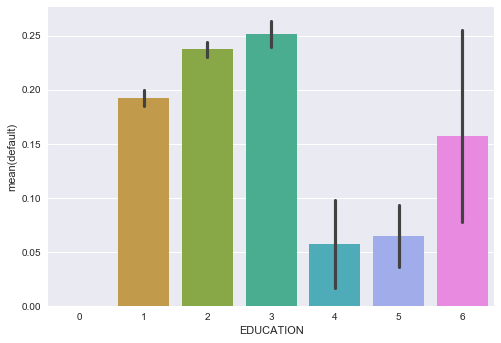

In [67]:
sns.barplot(x='EDUCATION', y='default',data=data)

Видим, что доля дефолтов выше среди людей, имеющих образование среднее и выше, кроме докторской степени. Возможно это говорит о том, что для тех, кто среднего образования не имеет процедуры кредитования значительно строже. Для тех, кто имеет образование среднее и выше, есть убывающая зависимость дефолтов от роста степени образованности. 

Уже сейчас можно ответить на вопросы в конце. Наличие докторской степени является лучшим индикатором того, что человек отдаст долг. Того, что не отдаст - наличие полного среднего образования.

В целом будем проверять гипотезу о зависимости признаков образования и дефолта на основании хи-квадрат статистики. Нулевая гипотеза: признаки независимы. Альтернатива - есть зависимость. 

Также посмотрим на коэффициент V Крамера. 

In [71]:
data['ones']=1

In [74]:
cont_table=np.array(pd.pivot_table(data,columns='EDUCATION',index='default',aggfunc=np.sum,values='ones',fill_value=0))

In [76]:
scipy.stats.chi2_contingency(cont_table)

(163.21655786997073,
 1.2332626245415605e-32,
 6L,
 array([[1.0903200e+01, 8.2435980e+03, 1.0926564e+04, 3.8293596e+03,
         9.5792400e+01, 2.1806400e+02, 3.9718800e+01],
        [3.0968000e+00, 2.3414020e+03, 3.1034360e+03, 1.0876404e+03,
         2.7207600e+01, 6.1936000e+01, 1.1281200e+01]]))

In [77]:
chi2=scipy.stats.chi2_contingency(cont_table)[0]

Гипотеза о независимости признаков отвергается с достигаемым уровнем значимости 1.23e-32. Значение cтатистики хи-квадрат 163.2166.
Коэффициент V крамера будет равен:


In [81]:
cramer=math.sqrt(chi2/cont_table.sum())

In [82]:
cramer

0.07376009713252163

Разницу ожиданий и реальности можно построить вычитая полученной в chi2_contingency процедуре матрицы ожидаемых значений нашу таблицу сопряженности.

In [83]:
difmat=scipy.stats.chi2_contingency(cont_table)[3]-cont_table

In [84]:
difmat

array([[  -3.0968, -305.402 ,  226.564 ,  149.3596,  -20.2076,  -43.936 ,
          -3.2812],
       [   3.0968,  305.402 , -226.564 , -149.3596,   20.2076,   43.936 ,
           3.2812]])

Для приведения к единому масштабу, можно разделить значения разницы на сумму таблицы сопряженности по столбцам:

In [89]:
difmat/cont_table.sum(axis=0)

array([[-0.2212    , -0.02885234,  0.01614854,  0.03037616, -0.16428943,
        -0.15691429, -0.06433725],
       [ 0.2212    ,  0.02885234, -0.01614854, -0.03037616,  0.16428943,
         0.15691429,  0.06433725]])

### 4. Семейное положение.

In [90]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

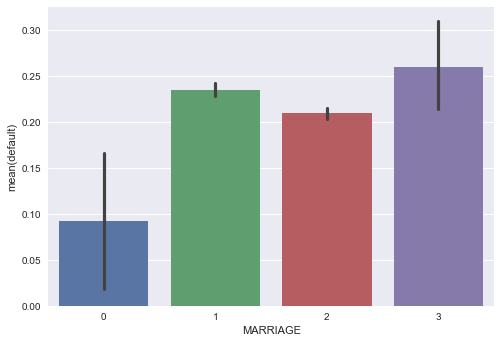

In [97]:
sns.barplot(x='MARRIAGE',y='default',data=data)

Учитывая малочисленность 0 можно их игнорировать. Однако мы видим, что в среднем для них дефолт ниже, в том числе с учётом доверительных интервалов (видно просто визуально на графике). Для 3 группы, для которой нет данных сказать такое сложнее. Предлагается игнорируя группу 0, провести попарное сравнение средних в 1,2 и 3. Уже на графике видно, что уровень дефолта среди замужних/женатых выше, чем среди холостых. 

Построим доверительные интервалы для долей для всех групп.

In [98]:
from statsmodels.stats.proportion import proportion_confint

In [99]:
prop_0=proportion_confint(sum(data.default[data.MARRIAGE==0]),len(data.default[data.MARRIAGE==0]),method='normal')
prop_1=proportion_confint(sum(data.default[data.MARRIAGE==1]),len(data.default[data.MARRIAGE==1]),method='normal')
prop_2=proportion_confint(sum(data.default[data.MARRIAGE==2]),len(data.default[data.MARRIAGE==2]),method='normal')
prop_3=proportion_confint(sum(data.default[data.MARRIAGE==3]),len(data.default[data.MARRIAGE==3]),method='normal')

In [106]:
print 'For 0:', prop_0
print 'For 1:', prop_1
print 'For 2:', prop_2
print 'For 3:', prop_3

For 0: (0.01528173453074011, 0.16990345065444507)
For 1: (0.22760945293217713, 0.24182461984035378)
For 2: (0.20297301446882615, 0.21559376077547354)
For 3: (0.21222283047806575, 0.30790100853122215)


Видим, что без применения более сложных методов уже видна зависимость: 0,1,2 имеют непересекающиеся доверительные интервалы, 3 же имеет пересекающиеся со 2 и 1. Для того, чтобы проверить гипотезу о равенстве долей рассмотрим z критерии о равенстве долей для 1-3 и 2-3.

Нулевая гипотеза - доли дефолтных клиентов равны в обоих подвыборках, альтернатива двусторонняя.

In [111]:
zcrit_two_shares(data.default[data.MARRIAGE==3],data.default[data.MARRIAGE==1])

0.2885313069730755

In [112]:
zcrit_two_shares(data.default[data.MARRIAGE==3],data.default[data.MARRIAGE==2])

0.02661521711844661

Видим, что гипотеза о равенстве средних не отвергается для комбинации 1-3. Для 3-2 она отвергается на уровне 0.05, достигаемый уровень значимости 0.027.

Для однозначного отображения зависимости исользуем коэффициент V крамера. (В принципе можно было бы избавиться от категорий 0 и 3 и тогда применить корреляцию Мэтьюса - она даст нам знать о характере зависимости больше, чем просто число от 0 до 1).

In [113]:
cont_table2=np.array(pd.pivot_table(data,columns='MARRIAGE',index='default',aggfunc=np.sum,values='ones',fill_value=0))

In [114]:
scipy.stats.chi2_contingency(cont_table2)

(35.66239583433609,
 8.825862457577375e-08,
 3L,
 array([[4.20552000e+01, 1.06376292e+04, 1.24327632e+04, 2.51552400e+02],
        [1.19448000e+01, 3.02137080e+03, 3.53123680e+03, 7.14476000e+01]]))

Гипотеза о незначимости зависимости между переменными отвергается на уровне 0.05. Достигаемый уровень значимости 8.83e-8.

In [115]:
cramer2=math.sqrt(scipy.stats.chi2_contingency(cont_table2)[0]/cont_table.sum())

In [116]:
cramer2

0.034478203662766466

Теперь проверим всё-же корреляцию Мэтьюса.

In [117]:
data_mod=data[(data.MARRIAGE!=0)&(data.MARRIAGE!=3)]

In [118]:
cont_table_mod=np.array(pd.pivot_table(data_mod,columns='MARRIAGE',index='default',aggfunc=np.sum,values='ones',fill_value=0))

In [119]:
cont_table_mod

array([[10453, 12623],
       [ 3206,  3341]], dtype=int64)

In [122]:
a=cont_table_mod[0,0]
b=cont_table_mod[0,1]
c=cont_table_mod[1,0]
d=cont_table_mod[1,1]

In [123]:
mcc=float(a*d-b*c)/math.sqrt((a+b)*(a+c)*(b+d)*(c+d))

In [124]:
mcc

-0.030555369920445503

Так как замужние здесь приняты за 0, то мы видим, что корреляция отрицательная, то есть замужние/женатые более склонны к дефолту в выборке, чем холостые, что подтверждает наши наблюдения по графику, а также то, что мы видели по доверительным интервалам.

### 5. Возраст

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000075F32588>,
      dtype=object)

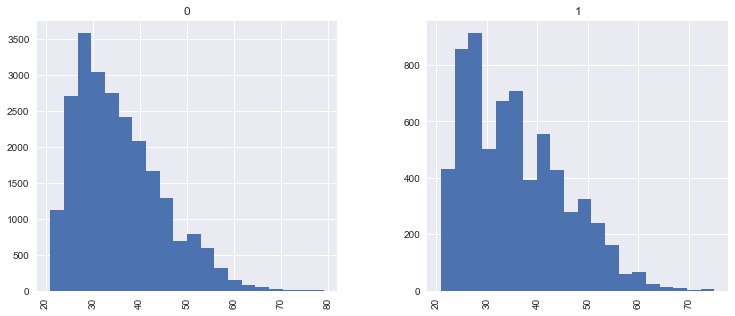

In [125]:
data.hist(column='AGE',by='default',figsize=(12,5),bins=20)

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([21, 21, 21, ..., 73, 73, 75], dtype=int64)),
 (9.453763999193253, 35.72573839662447, 0.9748432681275312))

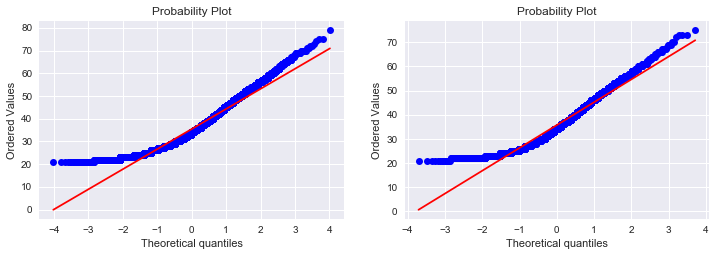

In [126]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data.AGE[data.default==0], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data.AGE[data.default==1], dist="norm", plot=pylab)

Выборка непохожа на нормальную - смещение влево, усечённая слева выборка и тяжелый левый хвост. В остальном, по выборке сложно сказать что-то по поводу смещения.

Проверим гипотезу о равенстве медиан:

In [128]:
ages_nodef=np.array(data.AGE[data.default==0])
ages_def=np.array(data.AGE[data.default==1])

In [132]:
nodeft2=get_bootstrap_samples(ages_nodef,10000)
deft2=get_bootstrap_samples(ages_def,10000)

In [133]:
statist2=np.median(nodeft2,axis=1)-np.median(deft2,axis=1)

(array([1013.,    0.,    0.,    0.,    0.,   48.,    0.,    0.,    0.,
        8939.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

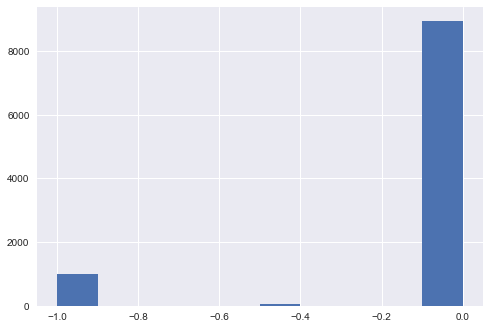

In [134]:
plt.hist(statist2)

In [135]:
stat_intervals(statist2,0.05)

array([-1.,  0.])

В доверительный интервал входит ноль - мы не можем отвергнуть нулевую гипотезу о равенстве медиан возраста в двух выборках - дефолтной и недефолтной.

Применим непараметрический критерий. Используем перестановочный критерий. Как и в первом пункте, проверяем гипотезу о равенстве распределений против двусторонней альтернативы, что распределения смещены друг относительно друга.

In [136]:
permutation_test(ages_nodef, ages_def, max_permutations = 10000)

0.0162

Нулевая гипотеза о равенстве распределений отвергается на уровне 0.05, достигаемый уровень значимости 0.0162. Таким образом, возраст смещён для тех, кто имел дефолт по отношению к тем, у кого не было дефолта.

На основании сравнения медиан, можно утверждать, что с практической точки зрения результат незначим, так как смещение если и имеет место, то практически мало, хотя и статистически значимо.